In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

def draw_plot(rang, *funcs, xlog=False, ylog=False, legend=None):
    xs = []
    ys = []
    for _ in funcs:
        ys.append([])
    
    for x in rang:
        xs.append(x)
        for i, f in enumerate(funcs):
            ys[i].append(f(x))
    
    for i, y in enumerate(ys):
        plt.plot(xs, y, label=None if legend is None else legend[i])
    
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')
    if legend:
        plt.legend()
    
    plt.show()
    
def list_func(l):
    return lambda n: l[n]

### Задание 11

Выпишем сеточную задачу:

Имеем следующее: 

$$ -\psi''(r) + l(l + 1)r^{-2}\psi(r) - 2r^{-1}\psi(r) = 2E_{nl}\psi(r), \psi(0) = \psi(\infty) = 0$$

$$ \psi''(r) - l(l + 1)r^{-2}\psi(r) + 2r^{-1}\psi(r) = -2E_{nl}\psi(r), \psi(0) = \psi(\infty) = 0$$

Перегруппируем под задачу:

$$ \psi''(r) - (l(l + 1)r^{-2} - 2r^{-1})\psi(r) = -2E_{nl}\psi(r), \psi(0) = \psi(\infty) = 0$$

Получили, что $p_n(r) = l(l + 1)r^{-2} - 2r^{-1}, \rho_n(r) = 1, \lambda_n = -2E_{nl}$

При $l = 0$: $p_n(r) = - 2r^{-1}, \rho_n(r) = 1, \lambda_n = -2E_{n0} = \frac{1}{(n + 1)^2}$

Итого сеточная задача:

$$\frac{y_{n + 1} - 2y_n + y_{n - 1}}{h^2} + 2r_n^{-1}y_n = \lambda y_n$$


Видно, что $\lambda$ можно получить просто как решения $Ay = \lambda y$.
Построим для этого дела матрицу $A$:

In [2]:
def E(n, l):
    return np.float64(-1.) / np.float64(2. * np.float64(n + l + 1)**2)

def get_a(N, R):
    h = np.float64(R) / np.float64(N)
    a = np.zeros((N - 1, N - 1))
    for i in range(N - 1):
        a[i][i] = np.float64(-2. / h**2) + 2./ np.float64(h * (i + 1.))
        if i != 0:
            a[i][i - 1] = np.float64(1. / h**2)
        if i != N - 2:
            a[i][i + 1] = np.float64(1. / h**2)
    return a
get_a(5, 10)

array([[ 0.5       ,  0.25      ,  0.        ,  0.        ],
       [ 0.25      ,  0.        ,  0.25      ,  0.        ],
       [ 0.        ,  0.25      , -0.16666667,  0.25      ],
       [ 0.        ,  0.        ,  0.25      , -0.25      ]])

Нам нужно получить точность в $10^{-5}$. Мы знаем, что точность имеет порядок $O(h^2)$, следовательно т.к. $h = \frac{R}{N}$, то для зафиксированного $R$ нужно вычислить $N$ как $O(\sqrt{\frac{R^2}{10^{-5}}})$. Построим на этом 5 собственных функций (понадеявшись, что внутри О скрывается коэффициент близкий к 1):

(0.9999960277669145, 0.22561221394424888, -0.18284458881139987, -0.8103075713194462, -1.6527739717907493)
[-0.5, -0.125, -0.05555555555555555, -0.03125, -0.02]


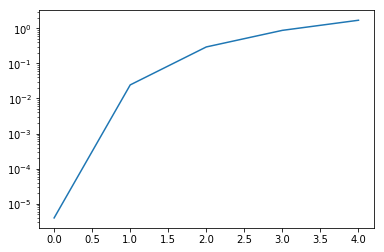

In [39]:
def get_N(R):
    return int(math.sqrt(R**2 * 10**5)) + 1

R = 10
N = get_N(R)

eval, evec =  np.linalg.eig(get_a(N, R))
ev_list = zip(eval, evec)
ev_list = sorted(ev_list, key=lambda tup:tup[0], reverse=True)
eval, evec = zip(*ev_list)

real_es = [E(i, 0) for i in range(5)]

print(eval[:5])
print(real_es)
draw_plot(range(5), list_func([abs(2. * real_e + eig) for eig, real_e in zip(eval[:5], real_es)]), ylog=True)


Как видно, первое собственное число действительно оказалось близко к рельному с $\varepsilon = 10^{-5}$. То, что так не произошло с остальными векторами может быть комбинацией двух факторов: $R$ недостаточно ушло в бесконечность и внутри O на самом деле прячется чуть более сложная константа. (Но то, что числа переходят через 0 -- это точно первое).

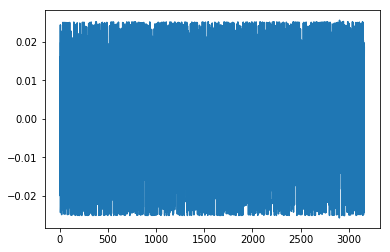

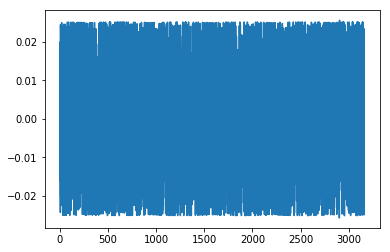

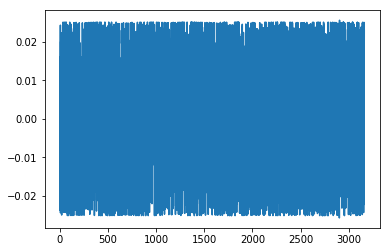

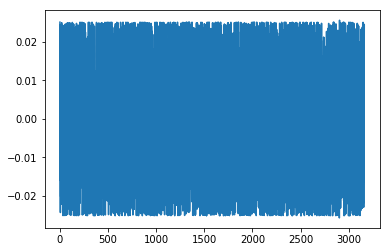

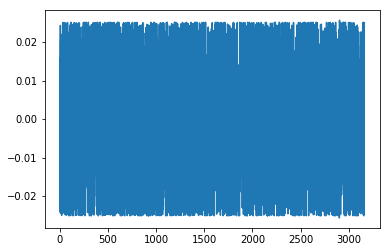

In [40]:
for vec in evec[:5]:
    draw_plot(range(0, N - 1), list_func(vec))

Тут ничего не видно. Увы.

Составим матрицу для метода Нумерова (возьмём числа из презентации)

In [85]:
def get_a_numerov(N, R):
    h = np.float64(R) / np.float64(N)
    a = np.zeros((N - 1, N - 1))
    
    for i in range(N - 1):
        a[i][i] = np.float64(2. / h ** 2) - (1. - np.float64(1.) / np.float64(6.)) * 2./ np.float64(h * (i + 1.))
        if i != 0:
            a[i][i - 1] = np.float64(-1. / h ** 2) - (np.float64(1.) / np.float64(12.)) * 2./ np.float64(h * i)
        if i != N - 2:
            a[i][i + 1] = np.float64(-1. / h ** 2) - (np.float64(1.) / np.float64(12.)) * 2./ np.float64(h * (i + 2.))
    return a

get_a_numerov(5, 10)

array([[-0.33333333, -0.29166667,  0.        ,  0.        ],
       [-0.33333333,  0.08333333, -0.27777778,  0.        ],
       [ 0.        , -0.29166667,  0.22222222, -0.27083333],
       [ 0.        ,  0.        , -0.27777778,  0.29166667]])

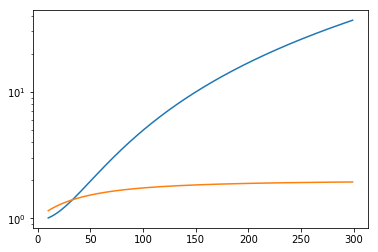

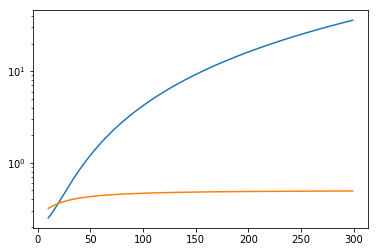

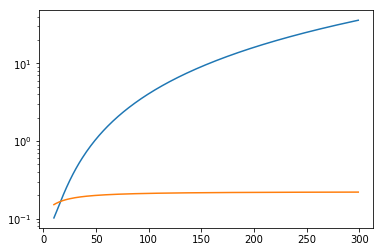

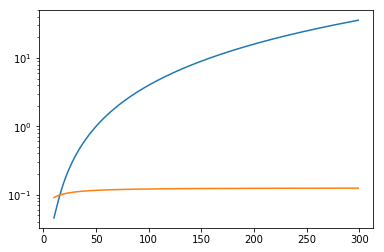

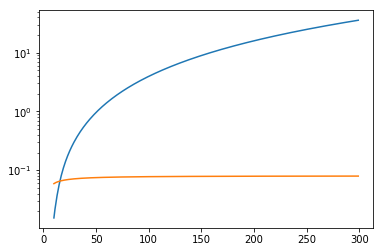

In [88]:
real_es = [E(i, 0) for i in range(5)]

R = 100

for i in range(5):
    draw_plot(range(10, 300), lambda N: abs(sorted(np.linalg.eig(get_a(N, R))[0])[i] + 2 * real_es[i]),
                              lambda N: abs(sorted(np.linalg.eig(get_a_numerov(N, R))[0])[i] + 2 * real_es[i]), ylog=True)




Случился очевидный прогресс.